In [10]:
import sys, os

# adjust based on what Step 1 printed
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

print("Path added:", os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

# now try again
from simulation import load_layout, compute_distance_map, spread_fire_and_smoke, in_bounds
print("Successfully imported simulation.py")


Path added: /mnt/c/Users/marti/Uni/Uni 2025/Computational Modelling/Proj/cits4403-evacuation-simulation/src
Successfully imported simulation.py


In [11]:
from simulation import load_layout, compute_distance_map, spread_fire_and_smoke, in_bounds
import os, sys, random, matplotlib.pyplot as plt
from simulation import load_layout, compute_distance_map, spread_fire_and_smoke
import pygame

# Evacuation Simulation – Panic Behaviour and Building Layouts

This notebook demonstrates an agent-based evacuation simulation that models how groups of people escape a building under different structural layouts and panic levels.  

We will measure survivability which is the number of agents that successfully exit across different conditions:

- Exit placement – How the position of exits affects evacuation efficiency.  
- Room structure – How walls and corridors shape crowd flow.  
- Fire & smoke spread – How the placement of fire affects agents.  
- Panic level – How an agents ability to move efficiently to an exit affects survivability.  


## Running and Editing the Simulation

You can run the simulation and modify the world layout yourself.

In the simulation window:
- Use 1 then left click to place/remove walls.  
- Use 2 then left click to place/remove agents.  
- Use 3 then left click to place/remove exits.  
- Use 4 then left click to place/remove fire.  
- Press SPACE to start or pause the simulation.  
- Press L to load one of the pre built layout demos (ensure in the code you have the right layout name selected before clicking L).  
- Press S to save your custom layout (ensure to change its name after you've saved it).  

Each agent has attributes like speed, age, and panic level (1–10).  
Higher panic makes the agent more likely to take random, non-optimal paths.

### Launching the Simulation

Since this is a notebook file the live Pygame window cannot appear here.  
Instead, open a Windows/macOS terminal and run:

python src/simulation.py

You can then modify the line in the code that loads the layouts to change the name to the layout you desire. 

# Demonstration Scenarios

We will now look at three pre-configured layouts that illustrate different evacuation behaviours:

1. Close Exits Layout – multiple nearby exits blocked by a single hazard.  
2. Confusing Building Layout – maze-like walls and multiple exits, causing confused routing.  
3. Dense Corridor Layout – a large style room leading to a single narrow exit, simulating crowd bottlenecks.

For each layout, we will:
- Load the design.  
- Visualise its structure.  
- Discuss the observed evacuation outcome.


In [12]:
# Imports
import os, sys, random, json
import matplotlib.pyplot as plt
import numpy as np

# Add path to simulation source
sys.path.append("../src")

from simulation import load_layout

# Ensure reproducibility
random.seed(42)

# Helper: visualise loaded layout
def visualize_layout(grid, title="Layout Preview"):
    plt.figure(figsize=(6,6))
    plt.imshow(np.array(grid), cmap="coolwarm", origin="upper")
    plt.title(title)
    plt.axis("off")
    plt.show()


## Demo 1: Close Exits Layout — The Illusion of Safety

This layout models a building with three exits where two exits are placed close together while one is positioned further away.  
At first it appears to offer multiple safe escape routes however, having exits too close to each other can create a false sense of security.

When a fire starts near the grouped exits, immediately a lot of the major exit paths become blocked.  
As a result, even with multiple exits available the effective number of usable exits drops to one leading to crowding and longer evacuation times.  
This scenario replicates real-world designs where exits are placed overly close to each other in buildings, a problem seen in nightclubs, cinemas, and older buildings.

We load and visualise the closeExits_layout.json configuration to illustrate this scenario.


Loaded layout: closeExits_layout.json
Loaded layout with 150 agents, 3 exits, 1 fire sources.


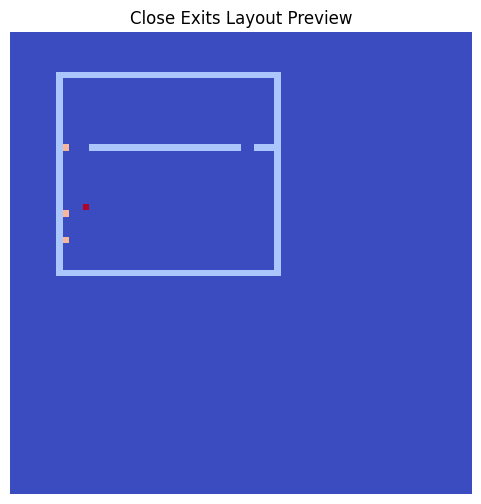

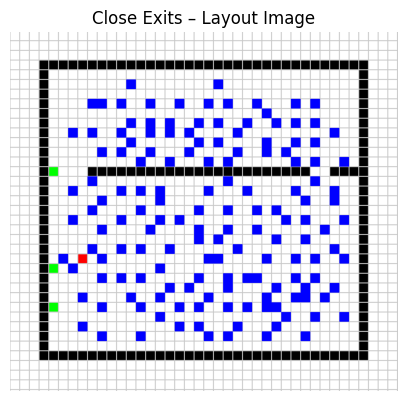

In [13]:
# existing lines (keep as-is)
grid, agents, exits, fires = load_layout("closeExits_layout.json")
print(f"Loaded layout with {len(agents)} agents, {len(exits)} exits, {len(fires)} fire sources.")
visualize_layout(grid, "Close Exits Layout Preview")  # unchanged

# NEW: show the reference PNG right below
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "../data/layout_images/closeExits.png"  # your saved PNG
img = mpimg.imread(image_path)

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Close Exits – Layout Image")
plt.axis("off")
plt.show()


### Simulation Results and Interpretation

We ran the simulation using the *Close Exits* layout across different panic levels for 150 agents:

| Panic Level | Fatalities | Survivors |
|--------------|-------------|------------|
| 2 (low)      | 7           | 143        |
| 4 (medium)   | 25          | 125        |
| 5 (high)     | 54          | 96         |

In this model, each agent has a panic level that determines how likely they are to make a non-optimal movement at any time tick.  
For example:
- A panic level of 2 means there is a 20% chance per tick that the agent will move in a sub optimal direction.
- A panic level of 5 gives a 50% chance and so on. 

This randomness simulates human error and delays seen during real evacuations such as people waiting for friends or family, hesitating, following crowds instinctively, or becoming disoriented in environments.

As panic increases, agents spend more time making poor movement choices, creating choke points and crowding near exits.  
In this layout specifically since two exits are grouped close together the fire spreading in that area quickly makes both unusable.  
Agents continue trying to leave through these blocked exits instead of going to the further one.

The results show a nonlinear increase in fatalities as panic rises
The uprpose here is to highlight the importance of:
- Strategic exit placement that avoids clustering. More specifically, buildings are often classed as fire-safe due to having many exits, without going through a consideration of where those exits are actually placed and how close they are too eachother. 


## Demo 2: Dense Corridor Layout — Single-File Bottlenecks

This layout emulates a closed venue plan: a large gathering space leads into a long narrow corridor that leads to a single usuable exit. 

The purpose of modelling this was to show the layout results in queuing and clustering at the doorway, stop-and-go waves in the corridor, and high sensitivity panic. In this scenario the fire starts at the far end of the room and agents rush through the narrow corridor toward the only exit. As more agents pile up near the doorway, clusters form some agents make it out while others are forced to wait outside the corridor as the fire and smoke close in.

Below we load and visualise `DenseCorridor_layout.json` to show the structure of the room with the single narrow exit. 


Loaded layout: DenseCorridor_layout.json
Loaded layout with 150 agents, 1 exits, 23 fire sources.


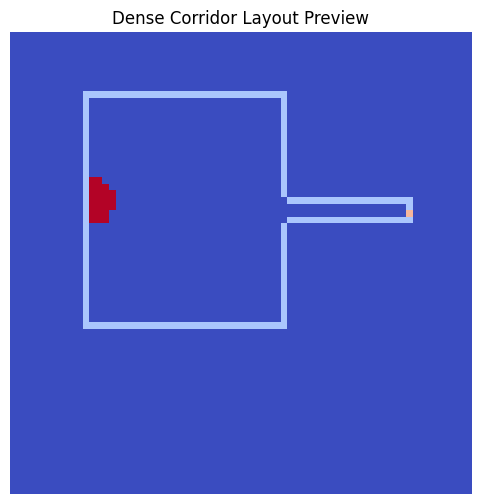

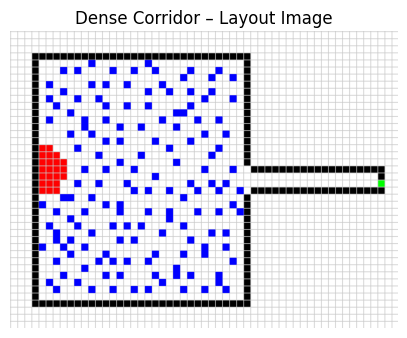

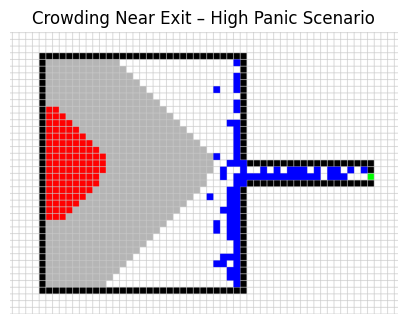

In [16]:
grid, agents, exits, fires = load_layout("DenseCorridor_layout.json")
print(f"Loaded layout with {len(agents)} agents, {len(exits)} exits, {len(fires)} fire sources.")

visualize_layout(grid, "Dense Corridor Layout Preview")

layout_path = "../data/layout_images/DenseCorridor.png" 
img = mpimg.imread(layout_path)

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Dense Corridor – Layout Image")
plt.axis("off")
plt.show()

crowding_path = "../data/layout_images/crowdingExit.png"
crowd_img = mpimg.imread(crowding_path)

plt.figure(figsize=(5, 5))
plt.imshow(crowd_img)
plt.title("Crowding Near Exit – High Panic Scenario")
plt.axis("off")
plt.show()


### Simulation Results and Explanation

We ran the Dense Corridor simulation for 150 agents.

| Panic Level | Fatalities | Survivors |
|--------------|-------------|------------|
| 2 (low)      | 0           | 150        |
| 4 (medium)   | 27          | 123        |
| 5 (high)     | 49          | 101        |

Like the previous demo increasing panic caused a much higher number of fatalities. At low panic, every agent escaped safely and this is similar to what happens in real life, of people are prepared and ready, not panicked, they are able to exit efficiently. 

In this layout the agents have to go through one narrow corridor to reach the exit.  This creates clusters and jams in the corridor. Agents at the back are forced to wait as those near the door struggle to move through, and some become trapped as the fire and smoke spread.

This shows strong emergent behaviour: even small increases in panic cause major slowdowns when many agents share a single exit. The model highlights how crowding naturally forms in high-stress situations, and how movement errors quickly lead to more deaths. 

Even though the model does not simulate physical pushing or crushing, the pattern is clear. The rise from 0 to 27 to 49 deaths shows how panic and limited exits combine to create dangerous evacuation outcomes.
